# *Tropical cyclone* vs *Extratropical cyclone* binary classifier
In this notebook we will create our Deep Learning model for the TC-xTC binary classifier. We will be using the framework `keras` and the library `pyphoon`. For this task we assume previous generation of the dataset.

## 0. Load libraries
Anything will work if there are no libraries imported. So lets import!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../../..')

from os.path import join
from os import environ, listdir

import h5py
import numpy as np

from pyphoon.app.utils import load_h5datachunks, parse_to_tcxtc_task
from pyphoon.app.preprocess import MeanImagePreprocessor

# Import keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


We will use GPU with identifier "1", after agreeing with other users with access to the same machine. If you are not using GPU or don't have any restriction on GPU usage skip this step.

In [3]:
environ["CUDA_VISIBLE_DEVICES"]="1"

## 1. Load data
Time to load the data. The data is stored in chunk HDF5 files, which have been previously been generated using script [generate_dataset.py](../../../scripts/generate_dataset.py). We will use chunks 0-26 for training, 27-24 for validation and 35-47 for testing. Note that loading the chunks might take a while. Grab yourself a tee.

In [4]:
# Paths where data is stored
dataset_dir = '/root/fs9/lucas/data/datasets/year_512/'
chunk_filenames = listdir(dataset_dir)
train_chunk_filenames = chunk_filenames[:27]
valid_chunk_filenames = chunk_filenames[27:35]
test_chunk_filenames = chunk_filenames[35:]

In [5]:
X_train, Y_train, idx_train, seqno_train = load_h5datachunks(dataset_dir,
                                                             train_chunk_filenames, 
                                                             features=['data', 'class', 'idx', 'seq_no'],
                                                             ignore_classes=[7],
                                                             display=True
                                                             )

X_valid, Y_valid, idx_valid, seqno_valid = load_h5datachunks(dataset_dir,
                                                             valid_chunk_filenames, 
                                                             features=['data', 'class', 'idx', 'seq_no'],
                                                             ignore_classes=[7],
                                                             display=True
                                                            )

X_test, Y_test, idx_test, seqno_test = load_h5datachunks(dataset_dir, 
                                                         test_chunk_filenames, 
                                                         features=['data', 'class', 'idx', 'seq_no'],
                                                         ignore_classes=[7],
                                                         display=True
                                                         )

 file chunk_0.h5 read
 file chunk_1.h5 read
 file chunk_2.h5 read
 file chunk_3.h5 read
 file chunk_4.h5 read
 file chunk_5.h5 read
 file chunk_6.h5 read
 file chunk_7.h5 read
 file chunk_8.h5 read
 file chunk_9.h5 read
 file chunk_10.h5 read
 file chunk_11.h5 read
 file chunk_12.h5 read
 file chunk_13.h5 read
 file chunk_14.h5 read
 file chunk_15.h5 read
 file chunk_16.h5 read
 file chunk_17.h5 read
 file chunk_18.h5 read
 file chunk_19.h5 read
 file chunk_20.h5 read
 file chunk_21.h5 read
 file chunk_22.h5 read
 file chunk_23.h5 read
 file chunk_24.h5 read
 file chunk_25.h5 read
 file chunk_26.h5 read
 file chunk_27.h5 read
 file chunk_28.h5 read
 file chunk_29.h5 read
 file chunk_30.h5 read
 file chunk_31.h5 read
 file chunk_32.h5 read
 file chunk_33.h5 read
 file chunk_34.h5 read
 file chunk_35.h5 read
 file chunk_36.h5 read
 file chunk_37.h5 read
 file chunk_38.h5 read
 file chunk_39.h5 read
 file chunk_40.h5 read
 file chunk_41.h5 read
 file chunk_42.h5 read
 file chunk_43.h5 rea

Since our task is focused on the binary distinction between *Tropical Cyclones* and *Extratropical Cyclones* we use the method `parse_to_tcxtc_task` prior tu training. This makes sure that we have two labels: 0 for *Tropical Cyclones* and 1 for *Extratropical Cyclones*. Furthermore, we make sure that we have a balanced category distribution, which basically means two things:

1. The amount of xTC and TC samples is roughly of 50% each.
2. Considering only TC samples, there is a nearly uniform distribution of samples from categories 2, 3, 4 and 5. 

In [6]:
# test
print("test...")
for i in range(len(Y_test)):
    # Get labels and valid positions
    Y_test[i], pos = parse_to_tcxtc_task(Y_test[i])
    # Retrieve corresponding samples
    X_test[i] = X_test[i][pos]
    idx_test[i] = idx_test[i][pos]
    seqno_test[i][pos] = seqno_test[i][pos]
    
# valid
print("valid...")
for i in range(len(Y_valid)):
    # Get labels and valid positions
    Y_valid[i], pos = parse_to_tcxtc_task(Y_valid[i])
    # Retrieve corresponding samples
    X_valid[i] = X_valid[i][pos]
    idx_valid[i] = idx_valid[i][pos]
    seqno_valid[i][pos] = seqno_valid[i][pos]
    
# train
print("train...")
for i in range(len(Y_train)):
    # Get labels and valid positions
    Y_train[i], pos = parse_to_tcxtc_task(Y_train[i])
    # Retrieve corresponding samples
    X_train[i] = (X_train[i][pos])
    idx_train[i] = idx_train[i][pos]
    seqno_train[i][pos] = seqno_train[i][pos]

test...
valid...
train...


## 2. Data Preprocessing

First of all, let us gain some knowledge of our data by printing the amount of samples in training, validation and test sets.

In [7]:
# Number of samples in dataset
n1 = sum([len(x) for x in X_train])
n2 = sum([len(x) for x in X_valid])
n3 = sum([len(x) for x in X_test])
print("train:", n1)
print("valid:", n2)
print("test:", n3)
print("total:", n1+n2+n3)

train: 24569
valid: 5625
test: 6913
total: 37107


Note that to preprocess the images (centre and normalise) we require the preprocessing parameters. Hence, these parameters will depend on the dataset being used. Currently, there are two dataset versions:

- **year sequence**: The trainig, validation and test datasets have been generated at sequence level. That is, images belonging to the same typhoon sequence find themselves only in one set. In addition, sequences from old typhoons have been used for training, while newer are used for testing. These parameters are found under `'../preprocessing_year.h5'`. 
- **random**: The training, validation and test datasets have been generated at image level. That is, totally random, meaning that images from same sequences may be found in different sets. These parameters are found under `'../preprocessing_random.h5'`.

These files, contain (for shapes 256x256 and 128x128) the following preprocessing parameters:

- Mean image: Image containing the mean for each pixel location.
- Pixel mean: Overal pixel intensity mean (scalar value).
- Pixel standard deviation: Overall pixel standard deviation (scalar value).
- Pixel maximum value: Overall maximum pixel intensity value (scalar value).
- Pixel minimum value: Overall minimum pixel intensity value (scalar value).

Depending on your needs, you may use `MeanImagePreprocessor` or`DefaultImagePreprocessor` to preprocess your data. Generation of these files is easy, and is done by `pyphoon.app.preprocess.generate_preprocess_params`. Set variable `generate_params` below to True to do so, however, the repository already provides precomputed preprocessing parameters.

In [10]:
generate_params = False
if generate_params:
    from pyphoon.app.preprocess import generate_preprocess_params
    generate_preprocess_params(X_train, "../preprocessing_year.h5")

Let us actually load the repository preprocessing parameters and preprocess the data. We resize the images, so as to work with 256 x 256 images instead of 512x512. Finally, we reshape the arrays such that they can be used by Keras.

In [18]:
# Define preprocessor
from pyphoon.app.preprocess import MeanImagePreprocessor
import cv2
with h5py.File('../preprocessing_year.h5') as f:
    mean = cv2.resize(f.get('image_mean').value, (256, 256))
    scale_factor = f.get('max_value').value - f.get('min_value').value

preprocessor = MeanImagePreprocessor(mean, scale_factor, add_axis=[3], resize_factor=(256, 256))

In [29]:
# Expand dimensions to be suitable for friend keras
X_train = [preprocessor.apply(x) for x in X_train]
X_valid = [preprocessor.apply(x) for x in X_valid]
X_test = [preprocessor.apply(x) for x in X_test]

## 3. Model architecture
Now, time to define our model. We directly implement the final architecture, with the hyper-parameters that provided best result during the grid search.

In [30]:
# Hyperparameters
lr = 0.01
decay_rate = 0.01
momentum = 0.9
p_drop = 0.2
batch_size = 32

In [38]:
model = Sequential()
############################################################################
# Convolutional Layers
############################################################################
model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=(256, 256, 1), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
############################################################################
# Dense Layers
############################################################################
model.add(Flatten())

model.add(Dense(100, use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(p_drop))

model.add(Dense(50, use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())

############################################################################
# Output Layer
############################################################################
model.add(Dense(units=1, activation='sigmoid'))

In [39]:
# Define optimizer
optimizer = SGD(lr=lr, momentum=momentum, nesterov=False, decay=decay_rate)
# Load and compile model architecture
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## 4. Train

In this section we train the model from scratch. Alternatively, you may refer to section 5 to load pretrained weights.

## 4.1 Callbacks
Before training, we will define some usefull callbacks to supervise the training process. One of the most usefull callbacks is [Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which enables easy visualisation of loss and accuracy curves.

Make sure to use the following command to run the tensorboard client.

```
$ tensorboard --logdir=<path/to/log-directory> --port <port>
```

Once the model is training you may check its performance by navigating to `localhost:<port>`.

In [95]:
from pyphoon.app.callbacks import StoreModelWeights, OurTensorBoard, LossHistory

foldername = 'results'
storeweights_callback = StoreModelWeights(foldername, naming="val_acc")
tensorboard_callback = OurTensorBoard(foldername)
loss_callback = LossHistory()

callbacks = [loss_callback, storeweights_callback, tensorboard_callback]

Finally, To feed our model with input data we will use a data generator, provided by method `data_generator` from `pyphoon.app.utils`.

In [41]:
from pyphoon.app.utils import data_generator_from_chunklist

# Number train samples
n_train = sum([len(x) for x in Y_train])
n_valid = sum([len(x) for x in Y_valid])

# Number of full epochs, i.e. #times algorithm sees all the data
epochs = 10
batch_size = 32

# Train
model.fit_generator(
    generator=data_generator_from_chunklist(X_train, Y_train, batch_sz=batch_size),
    steps_per_epoch=n_train // batch_size,
    validation_data=data_generator_from_chunklist(X_valid, Y_valid, batch_sz=batch_size),
    validation_steps=n_valid // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
767/767 [==============================] - 37s 49ms/step - loss: 0.1505 - acc: 0.9429 - val_loss: 0.1305 - val_acc: 0.9536
Epoch 2/10
767/767 [==============================] - 35s 45ms/step - loss: 0.1130 - acc: 0.9584 - val_loss: 0.1144 - val_acc: 0.9563
Epoch 3/10
767/767 [==============================] - 35s 46ms/step - loss: 0.1035 - acc: 0.9615 - val_loss: 0.1257 - val_acc: 0.9541
Epoch 4/10
767/767 [==============================] - 38s 49ms/step - loss: 0.0947 - acc: 0.9668 - val_loss: 0.1365 - val_acc: 0.9382
Epoch 5/10
767/767 [==============================] - 35s 46ms/step - loss: 0.0865 - acc: 0.9704 - val_loss: 0.1231 - val_acc: 0.9518
Epoch 6/10
767/767 [==============================] - 33s 43ms/step - loss: 0.0802 - acc: 0.9716 - val_loss: 0.1364 - val_acc: 0.9448
Epoch 7/10
767/767 [==============================] - 36s 47ms/step - loss: 0.0760 - acc: 0.9729 - val_loss: 0.1150 - val_acc: 0.9527
Epoch 8/10
767/767 [==============================] - 35s 45ms

### 5. Load pre-trained weights
Here we load the weights that provided the best performance and evaluate the performance on the test data. l.

In [45]:
model.load_weights('../weights.hdf5')

## 5. Results

### 5.1 Test accuracy
We evaluate the model that performed best on the validation set on the test set. This is the final performance of our model.

In [84]:
# Prediction
y_pred = []
for x in X_test:
    y_pred.extend(np.round(model.predict(x)).astype(int)[:, 0])
# Ground truth
y_true = np.concatenate(Y_test).tolist()

acc_test = (np.array(y_true) == np.array(y_pred)).mean()

print("Accuracy on validation set:", acc_test)

Accuracy on validation set: 0.949081440764


### 5.2 Confusion matrix, precision, recall

Next, we obtain the confusion matrix using module `sklearn`.

In [91]:
from sklearn.metrics import confusion_matrix
import pandas as pd
pd.DataFrame(confusion_matrix(y_true, y_pred), 
             columns=['predicted TC','predicted xTC'], 
             index=['TC','xTC']
            )

,predicted TC,predicted xTC
TC,3375,89
xTC,263,3186


In [90]:
3186/(3186+89)

0.972824427480916

As expected, we have most of the samples in the diagonal, meaning that most samples sare correctly classified. Now, let us obtain the precision and recall values. Find below a brief intuition of what this parameters convey.

- Precision: Out of the samples positively predicted, how many are actually positive? Gives the accuracy on the samples of class 1. 

$$precision = \frac{T_p}{T_p+F_p},$$
    where $T_p$ and $F_p$ denote true positives and false positives, respectively.

- Recall: Out of the actual positive samples, how many are predicted as positives?

$$recall = \frac{T_p}{T_p+F_n},$$ 
    where $F_n$ denotes false negatives.

In [87]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)

print("Precision:", p)
print("Recall:", r)

Precision: 0.972824427481
Recall: 0.923746013337


So we see that 97.3% samples predicted as xTC are actual xTC and that from all xTC, 92.3% of them are predicted to be xTC.

### 5.3 Accuracy/Loss curves
We now obtain the loss and accuracy curves on the training and validation sets. Note that this only works if you run the training with Tensorboard, since it uses the log history to retrieve the validation and accuracy curves. 

In [97]:
# Make surefrom os import listdir
listdir(join(foldername, 'tensorboard_log'))

['events.out.tfevents.1523545504.97c10ae7d2cf']

Next, we retrieve the training information from the log generated by Tensorboard, hence, make sure that you have used Tensorboard! Also, replace the path to the event log file.

In [100]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
path_log_file = 'results_2/tensorboard_log/events.out.tfevents.1523545504.97c10ae7d2cf'
event_acc = EventAccumulator(path_log_file)
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# loss
_, subepochs, val_loss = zip(*event_acc.Scalars('val_loss'))
_, subepochs, train_loss = zip(*event_acc.Scalars('loss'))
# accuracy
_, subepochs, val_acc = zip(*event_acc.Scalars('val_acc'))
_, subepochs, train_acc = zip(*event_acc.Scalars('acc'))

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['val_loss', 'val_acc', 'loss', 'acc'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': True, 'run_metadata': []}


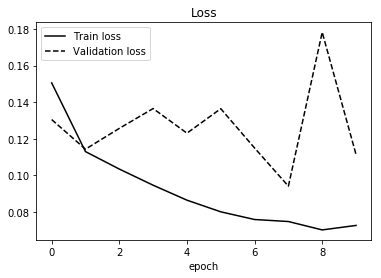

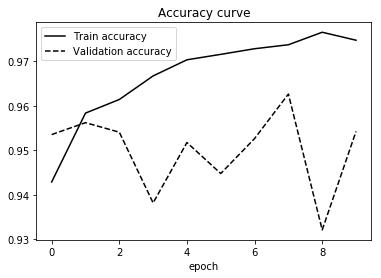

In [101]:
import matplotlib.pyplot as plt

# Loss
plt.plot(subepochs, train_loss, 'k')
plt.plot(subepochs, val_loss, 'k--')
plt.legend(['Train loss', 'Validation loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()
# plt.savefig('../_assets/loss_tcxtc.eps', format='eps', dpi=1000)

# Accuracy
plt.plot(subepochs, train_acc, 'k')
plt.plot(subepochs, val_acc, 'k--')
plt.legend(['Train accuracy', 'Validation accuracy'])
plt.title('Accuracy curve')
plt.xlabel('epoch')
plt.show()
# plt.savefig('../_assets/accuracy_tcxtc.eps', format='eps', dpi=1000)

From the results above, we clearly can see that the curve behaviour is quite unstable. This is mainly to the fact that the network rapidly converged and after 2 epochs is already satisfied so it tries to improve but just does some weird things. 